<a href="https://colab.research.google.com/github/ajmoore12/WPA_Competition/blob/main/wpac_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --upgrade google-cloud-bigquery-storage pandas

In [ ]:
# import torch
# print("GPU Available:", torch.cuda.is_available())

# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
from google.colab import files
import pandas as pd

project_id = 'wpac-449904'
dataset_id = 'wpac_data'
# Create a storage client
client = bigquery.Client(project=project_id)

In [ ]:
pd.set_option('display.max_columns', None)

# careers = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.cleaned_careers`").to_dataframe()
# jobs = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.cleaned_jobs`").to_dataframe()
all_time_connect = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.cleaned_all_time_connect`").to_dataframe()
individual = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.cleaned_individual`").to_dataframe()
other_events = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.cleaned_other_events`").to_dataframe()
# programs = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.cleaned_programs`").to_dataframe()
# resources = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.cleaned_resources`").to_dataframe()
survey = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.cleaned_survey`").to_dataframe()

In [ ]:
print(survey.shape)

(18607, 106)


In [ ]:
survey.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18607 entries, 0 to 18606
Data columns (total 106 columns):
 #    Column                                        Dtype  
---   ------                                        -----  
 0    children                                      object 
 1    concern_finances                              Int64  
 2    concern_health                                Int64  
 3    concern_job                                   Int64  
 4    concern_job_search                            Int64  
 5    concern_social                                Int64  
 6    contract_work                                 Int64  
 7    current_job_benefits_childcare                Int64  
 8    current_job_benefits_education                Int64  
 9    current_job_benefits_health                   Int64  
 10   current_job_benefits_none                     Int64  
 11   current_job_benefits_pto                      Int64  
 12   current_job_benefits_schedule               

In [ ]:
survey['cohort'] = survey['version'].str.extract(r'C(\d)')
survey.drop(columns=['version'], inplace=True)

targets_df = survey[['WPA_id', 'target_new_job', 'target_training_enrolled', 'cohort']].copy()

In [ ]:
targets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18607 entries, 0 to 18606
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   WPA_id                    18607 non-null  object 
 1   target_new_job            10654 non-null  float64
 2   target_training_enrolled  18042 non-null  float64
 3   cohort                    18607 non-null  object 
dtypes: float64(2), object(2)
memory usage: 581.6+ KB


In [ ]:
# Aggregate data: Sum target columns to count occurrences
targets_agg = targets_df.groupby('WPA_id').agg(
    {'target_new_job': 'max', 'target_training_enrolled':'max', 'cohort':'first'}).reset_index()


In [ ]:
# Convert all columns except 'WPA_id' to integers
for col in targets_agg.columns:
    if col != 'WPA_id':
        targets_agg[col] = pd.to_numeric(targets_agg[col], errors='coerce').fillna(0).astype(int)


In [ ]:
targets_agg.head()

,WPA_id,target_new_job,target_training_enrolled,cohort
0,WPA_10001,1,0,1
1,WPA_100040,0,0,7
2,WPA_100057,1,0,7
3,WPA_100087,0,0,7
4,WPA_100089,0,0,7


In [ ]:
target_event_merge = targets_agg.merge(all_time_connect, on='WPA_id', how='left')

In [ ]:
merge = target_event_merge.copy()

merge.head()

,WPA_id,target_new_job,target_training_enrolled,cohort,_id,sessionId,data_careerId,data_jobId,data_programId,data_resourceId,eventName_clicked on a resource,eventName_edited status,eventName_saved catalog item,eventName_viewed a catalog item,collectionType_careers,collectionType_jobs,collectionType_resources,collectionType_training
0,WPA_10001,1,0,1,658fac587aa35ecbf00ec229,96269fbe-0c89-4003-b3b8-4a6f89f5b62f,NA,NA,6407e4e10567c95e7dc83441,NA,0,0,0,1,0,0,0,1
1,WPA_10001,1,0,1,63918ef625eb8adb4b343da1,NA,NA,NA,628aece212545d84f96e6ff6,NA,0,0,0,0,0,0,0,1
2,WPA_10001,1,0,1,658fac6b7aa35ecbf00ec42c,96269fbe-0c89-4003-b3b8-4a6f89f5b62f,NA,NA,628aed1a12545d84f96e766a,NA,0,0,0,1,0,0,0,1
3,WPA_10001,1,0,1,658fac9c7aa35ecbf00ec5c3,96269fbe-0c89-4003-b3b8-4a6f89f5b62f,NA,NA,628aed1a12545d84f96e766a,NA,0,0,1,0,0,0,0,1
4,WPA_100040,0,0,7,6632cff7720bbd1b8b08473e,444fd58d-953e-4610-b668-576bc3451f64,NA,03b17f3dbfbbca9f88731b2b9b2ae89c4079ee5c,NA,NA,0,0,0,1,0,1,0,0


In [ ]:
# Aggregate merge data
merge_agg = merge.groupby('WPA_id').agg(
    {'target_new_job': 'first',
     'target_training_enrolled':'first',
     'cohort':'first',
     '_id':'nunique',
     'sessionId':'nunique',
     'data_careerId':'nunique',
     'data_jobId':'nunique',
     'data_programId':'nunique',
     'data_resourceId':'nunique',
     'eventName_clicked a catalog item':'sum',
     'eventName_completed a catalog item':'sum',
     'eventName_enrolled a catalog item':'sum',
     'collectionType_careers':'sum',
     'collectionType_jobs':'sum',
     'collectionType_programs':'sum',
     'collectionType_resources':'sum',
     'collectionType_survey':'sum',


     }).reset_index()

In [ ]:
for col in merge.columns:
  print(merge[col].value_counts(dropna=False))
  print('-'*100)

WPA_id
WPA_110437    640
WPA_49783     444
WPA_71033     415
WPA_76587     307
WPA_71994     269
             ... 
WPA_67283       1
WPA_2899        1
WPA_28974       1
WPA_28962       1
WPA_41182       1
Name: count, Length: 10106, dtype: int64
----------------------------------------------------------------------------------------------------
target_new_job
0    65324
1    19459
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
target_training_enrolled
0    49508
1    35275
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
cohort
6    23318
7    22026
5    16535
4     7447
3     6126
1     5814
2     3517
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
_id
NaN                         2064
65b9af5b2db0eee742e8f658       1
6584c26e7aa35ecbf0c8df80       1
6

In [ ]:
for col in merge1_enc_agg.columns:
  print(merge1_enc_agg[col].value_counts(dropna=False))
  print('-'*100)

WPA_id
WPA_99999     1
WPA_1         1
WPA_10        1
WPA_100       1
WPA_10000     1
             ..
WPA_100029    1
WPA_10003     1
WPA_100030    1
WPA_100031    1
WPA_100032    1
Name: count, Length: 132155, dtype: int64
----------------------------------------------------------------------------------------------------
eventName_clicked on a resource
0      132145
2           3
7           2
56          1
114         1
4           1
38          1
10          1
Name: count, dtype: Int64
----------------------------------------------------------------------------------------------------
eventName_edited status
0       127093
1          961
2          425
4          253
3          250
         ...  
437          1
1764         1
205          1
187          1
456          1
Name: count, Length: 281, dtype: Int64
----------------------------------------------------------------------------------------------------
eventName_saved catalog item
0       79033
1        8573
2        4675
3  

In [ ]:
print(merge1_enc_agg.head(), new_job_merge.head(), enrolling_merge.head())

       WPA_id  eventName_clicked on a resource  eventName_edited status  \
0       WPA_1                                0                        0   
1      WPA_10                                0                        0   
2     WPA_100                                0                        0   
3   WPA_10000                                0                        0   
4  WPA_100000                                0                        0   

   eventName_saved catalog item  eventName_viewed a catalog item  \
0                             1                                0   
1                             0                                0   
2                             0                                0   
3                             0                                0   
4                             0                                1   

   collectionType_careers  collectionType_jobs  collectionType_resources  \
0                       0                    0                  

In [ ]:
final_job_merge = new_job_merge.merge(merge1_enc_agg, on='WPA_id', how='left')
final_enrolling_merge = enrolling_merge.merge(merge1_enc_agg, on='WPA_id', how='left')
print(final_job_merge.shape, final_enrolling_merge.shape)

(6296, 128) (9713, 127)


In [ ]:
#Target Date has a mixed data type because of some users not entering a target date or is wasn't applicable
final_job_merge.drop(columns='targetDate', inplace=True)
final_enrolling_merge.drop(columns='targetDate', inplace=True)

In [ ]:
import pandas_gbq

dataset_table = "wpac_data.final_job_merge"  # Replace with dataset.table name

# Load your CSV into a DataFrame
csv_file_path = "final_job_merge.csv"  # Replace with your actual file path
# df = pd.read_csv(csv_file_path)

# Use `pandas_gbq.to_gbq` to upload DataFrame
pandas_gbq.to_gbq(
    final_job_merge,
    destination_table=dataset_table,
    project_id=project_id,
    if_exists="replace"  # "fail", "replace", "append"
)

dataset_table = "wpac_data.final_enrolling_merge"  # Replace with dataset.table name

# Load your CSV into a DataFrame
csv_file_path = "final_enrolling_merge.csv"  # Replace with your actual file path
# df = pd.read_csv(csv_file_path)

# Use `pandas_gbq.to_gbq` to upload DataFrame
pandas_gbq.to_gbq(
    final_enrolling_merge,
    destination_table=dataset_table,
    project_id=project_id,
    if_exists="replace"  # "fail", "replace", "append"
)

100%|██████████| 1/1 [00:00<00:00, 14169.95it/s]


# Code below will be used for further analysis later

In [ ]:
# Filter for only those who got a new job and deduplicate by WPA_id
filtered_matching_df = df[df['new_job'] == 1].drop_duplicates(subset=['WPA_id'])

# Define the reason and new job columns to compare
reason_cols = ['main_reason_advancement', 'main_reason_benefits', 'main_reason_better_hours',
               'main_reason_commute', 'main_reason_environment', 'main_reason_higher_pay']

new_job_cols = ['new_job_better_advancement', 'new_job_better_benefits', 'new_job_better_hours',
                'new_job_better_commute', 'new_job_better_environment', 'new_job_better_pay']

# Create a new DataFrame to track matches
filtered_matching_df['match_count'] = sum(
    filtered_matching_df[reason] == filtered_matching_df[new_job] for reason, new_job in zip(reason_cols, new_job_cols)
)

# Create a dictionary to track matches for each reason category
match_counts_by_reason = {}

# Compute matches for each reason and store them separately
for reason, new_job in zip(reason_cols, new_job_cols):
    filtered_matching_df[f'match_{reason}'] = filtered_matching_df[reason] == filtered_matching_df[new_job]

# Pivot table based on skillup_find_new_job and breaking out by reason
pivot_table_matching_breakout = filtered_matching_df.pivot_table(
    index='skillup_find_new_job',
    values=[f'match_{reason}' for reason in reason_cols],
    aggfunc='sum'  # Sum the matches for each reason category
)

pivot_table_matching_breakout


In [ ]:
filtered_matching_df.head()

In [ ]:
# Create a binary target column
filtered_matching_df['target'] = (
    (filtered_matching_df['skillup_find_new_job'] == 1) &  # Skillup helped find a new job
    (filtered_matching_df['new_job'] == 1) &  # They got a new job
    (filtered_matching_df['match_count'] > 0)  # At least one match between main_reason and new_job_better_
).astype(int)


In [ ]:
final_df = filtered_matching_df.drop(columns=['target', 'birth_year', 'year_quarter'], axis=1)

In [ ]:
sample_df = filtered_matching_df[['WPA_id', 'new_job', 'skillup_find_new_job', 'match_count', 'target']].sort_values(by='target', ascending=False).head(2000)

In [ ]:
# Save DataFrame to CSV
sample_df.to_csv('sample_df_target.csv', index=False)

# Download the file
files.download('sample_df_target.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

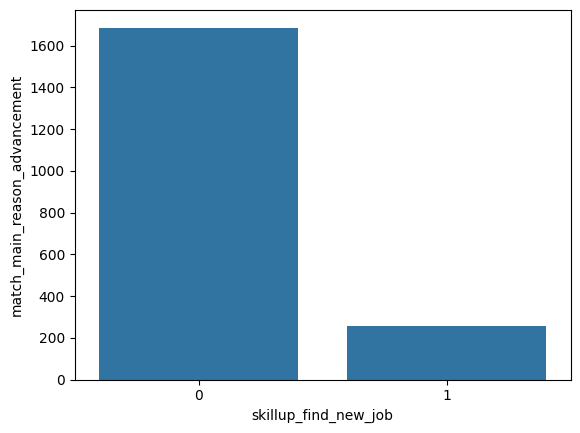

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=pivot_table_matching_breakout.reset_index(), x='skillup_find_new_job', y='match_main_reason_advancement')
plt.show()

In [ ]:
dataset_id = "wpac_data"

client = bigquery.Client(project=project_id)
datasets = [dataset.dataset_id for dataset in client.list_datasets()]
print("Available Datasets:", datasets)

if dataset_id not in datasets:
    print(f"Dataset {dataset_id} does not exist. Creating it now...")
    dataset_ref = client.dataset(dataset_id)
    dataset = bigquery.Dataset(dataset_ref)
    dataset.location = "US"  # Change if necessary
    client.create_dataset(dataset, exists_ok=True)
    print(f"Dataset {dataset_id} created.")


Available Datasets: ['wpac_data']


In [ ]:
import pandas_gbq

dataset_table = "wpac_data.merged_wpac"  # Replace with dataset.table name

# Load your CSV into a DataFrame
csv_file_path = "merged_wpac.csv"  # Replace with your actual file path
# df = pd.read_csv(csv_file_path)

# Use `pandas_gbq.to_gbq` to upload DataFrame
pandas_gbq.to_gbq(
    df,
    destination_table=dataset_table,
    project_id=project_id,
    if_exists="replace"  # "fail", "replace", "append"
)


100%|██████████| 1/1 [00:00<00:00, 7073.03it/s]
